
---
# GRAD CHALLENGE 2 (RNA GENE FINDING): 
---


## Name: Levi Zell


<br>

### Goal:
    Using any approach you like, find the RNA genes (including ncRNA, tRNA, and other non-translated RNA genes such as ribosomal RNAs) in an undisclosed genome of roughly 2Mb. 

### Requirements:

    Your program must run in less than one minute (1-year-old Xeon with 4 cores / 8 threads, 16GB RAM, no internet connection). Any window output by your program that overlaps with at least one annotated RNA gene will give you +1 point. Any window output by your program that overlaps with no annotated RNA genes penalizes -4 points.

### Input:

    Your program will accept one argument, the name of a file that contains a single string for the genome (this file is simpler than a FASTA file: it has no >SOME_GENE annotation line and has no whitespace, only capital `G', `A', `T', and `C'). 
    
### Output:

    Your program will print each window with a predicted RNA gene as
	      window_1_start window_1_end
	      window_2_start window_2_end
	      .
	      .
	      .
	    
Window indices start at 0 and are inclusive: e.g., the window 8 10 includes bases 8, 9, and 10 (which are actually the 9th, 10th, and 11th bases when starting with base 1).

Make your code from scratch with no imported libraries (C++ code may use the standard library). C++ entries will be compiled using the flags specified above. 

Python code may use the stardard library AND numpy

<br>

### ***DUE DATE:*** Monday November 12, 2018 

<br> 
<br>

## Imports
 
 ---

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import glob
import sys
import tensorflow as tf
import numpy as np
import pandas as pd 
import pdb
import scipy
import random

C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from tensorflow import keras, image
from tensorflow.keras import layers, models
from tensorflow.keras.layers import SeparableConv1D, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import UpSampling1D, UpSampling2D, Add

from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, Activation, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, ZeroPadding1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
keras version 2.1.6-tf
tensorflow version 1.12.0


### Make Conv1DTranspose function since Keras does not yet support it

In [5]:
# source: https://stackoverflow.com/a/45788699/6442709
# credit: Dingkun Liu
  
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
  x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
  x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
  x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
  return x

<br><br>

---
# Code
---

<br>

In [53]:
fname='staph.genome'
gen_string=''
with open(fname, 'r') as f:
  with open('staph_aur.genome', 'w') as s:
    for line in f.readlines():
#       print(line)
      gen_string+=str(line).strip()
    s.write(gen_string)
    s.close()
# text_file = open("Output.txt", "w")
# text_file.write("Purchase Amount: %s" % TotalAmount)
# text_file.close()

In [55]:
with open('staph_aur.genome') as s:
  print(len(s.readlines()[0]))
#   print(len(s.readlines()))

834060


### Write .genbank gene indicies to file

In [285]:
import re

# with open('gene_indicies.txt', 'w') as genes:
fname = 'pyrococcus_furiosus.genbank'
      
with open('genes_ind.txt', 'w') as genes:
  with open(fname, 'r') as genfile:
    for line in genfile.readlines():
      if not re.match(r'^\s*$', line):
        if line.split(None, 1)[0] == 'gene':
          if re.findall('\d+', line): # if list isn't empty
            genes.write(str(re.findall('\d+', line)[0])+' '+re.findall('\d+', line)[1]+ '\n')


In [60]:
import re

# with open('gene_indicies.txt', 'w') as genes:
fname = 'staph.genbank'
      
with open('staph_genes_ind.txt', 'w') as genes:
  with open(fname, 'r') as genfile:
    for line in genfile.readlines():
      if not re.match(r'^\s*$', line):
        if line.split(None, 1)[0] == 'gene':
          if re.findall('\d+', line): # if list isn't empty
            genes.write(str(re.findall('\d+', line)[0])+' '+re.findall('\d+', line)[1]+ '\n')


<br> 

### Convert genome sequence to numpy array

In [63]:
fname = "./data/pyrococcus_furiosus.genome"

genome = open(fname)
gen_str = genome.readlines()
gen_lst = list(gen_str[0])
gen_arr = np.asarray(gen_lst)

print(type(gen_arr), gen_arr.size, gen_arr)


<class 'numpy.ndarray'> 1908256 ['A' 'A' 'T' ... 'G' 'T' 'G']


In [62]:
fname = "staph_aur.genome"

staph_genome = open(fname)
staph_gen_str = staph_genome.readlines()
staph_gen_lst = list(staph_gen_str[0])
staph_gen_arr = np.asarray(staph_gen_lst)

print(type(staph_gen_arr), staph_gen_arr.size, staph_gen_arr)


<class 'numpy.ndarray'> 834060 ['T' 'C' 'A' ... 'G' 'A' 'T']


<br>

### one-hot encode sequences before training (0=A, 1=T, 2=C, 3=G)

In [64]:
bases_list = ['A', 'T', 'C', 'G']

le = preprocessing.LabelEncoder()
le.fit(bases_list)
list(le.classes_)
pyro=le.transform(gen_lst)
list(le.inverse_transform([0, 1, 2, 3]))


C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['A', 'C', 'G', 'T']

In [72]:
bases_list = ['A', 'T', 'C', 'G']

le = preprocessing.LabelEncoder()
le.fit(bases_list)
list(le.classes_)
staph=le.transform(staph_gen_lst)
list(le.inverse_transform([0, 1, 2, 3]))


C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['A', 'C', 'G', 'T']

<br>

### same label indicies and genome sequence to file



In [74]:
label = np.zeros(pyro.shape[0], dtype='int')

with open('genes_ind.txt', 'r') as genes:
  
  f = genes.readlines()
  
  for i in range(0, len(f)): # get each RNA seq indicies
    rna_start_ind = int(f[i].split(' ')[0])-1
    rna_end_ind = int(f[i].split(' ')[1])
    
    for k in range(rna_start_ind, rna_end_ind):
      label[k] = int(1)

with open('genes_lbl.txt', 'w') as genes_lbl:
  for i in label:
    genes_lbl.write('{}'.format(i))

with open('genome.txt', 'w') as genome:
  for i in pyro:
    genome.write('{}'.format(i))



In [73]:
staph_label = np.zeros(staph.shape[0], dtype='int')

with open('staph_genes_ind.txt', 'r') as genes:
  
  f = genes.readlines()
  
  for i in range(0, len(f)): # get each RNA seq indicies
    rna_start_ind = int(f[i].split(' ')[0])-1
    rna_end_ind = int(f[i].split(' ')[1])
    
    for k in range(rna_start_ind, rna_end_ind):
      staph_label[k] = int(1)

with open('staph_genes_lbl.txt', 'w') as genes_lbl:
  for i in staph_label:
    genes_lbl.write('{}'.format(i))

with open('staph_genome.txt', 'w') as genome:
  for i in staph:
    genome.write('{}'.format(i))



<br><br>

---
# Start Here if .txt files have already been made
---

<br>

<br>

### Segment genome into segments so can be computed

In [6]:
def segment_genome(start_ind, end_ind, pos_ind, line_ind, max_gene_ind, max_seq_len=10000):
  """
  Segments Genome into sections of length 'max_seq_len' which equals 10,000 by default
  """
  
  temp_seq = ''
  temp_lbl = '' 
  
#     rna_start_ind = int(gi[line_ind].split(' ')[pos_ind])-1
#     rna_end_ind = int(gi[line_ind].split(' ')[pos_ind+1])      
#     rna_next_ind = int(gi[line_ind+1].split(' ')[0])-1
    
  while (len(temp_seq) < max_seq_len) & (line_ind < len(gi)-2):
      
    if ((end_ind - start_ind + len(temp_seq)) < max_seq_len):
      if len(ge[start_ind:end_ind])>0:
        temp_seq+=str(ge[start_ind:end_ind])
        temp_lbl+=str(gl[start_ind:end_ind])
        
        if pos_ind==1: # if pos_ind==1 (end_ind was rna_end_ind of current line)
          line_ind+=1
          pos_ind-=1
          start_ind = end_ind # becomes rna_end_ind of SAME line
          end_ind = int(gi[line_ind].split(' ')[pos_ind])-1  # rna_start_ind of NEXT line
          
        else: # if pos_ind==0 (end_ind was start_ind of same line)
          pos_ind+=1
          start_ind = end_ind # becomes rna_start_ind of current line 
          end_ind = int(gi[line_ind].split(' ')[pos_ind]) # becomes rna_end_ind of current line
        
      else:
        if pos_ind==1: # if pos_ind==1 (end_ind was rna_end_ind of current line)
          line_ind+=1
          pos_ind-=1
          start_ind = end_ind # becomes rna_end_ind of SAME line
          end_ind = int(gi[line_ind].split(' ')[pos_ind])-1  # rna_start_ind of NEXT line
          
        else: # if pos_ind==0 (end_ind was start_ind of same line)
          pos_ind+=1
          start_ind = end_ind # becomes rna_start_ind of current line 
          end_ind = int(gi[line_ind].split(' ')[pos_ind]) # becomes rna_end_ind of current line
        
    else: 
      break

  while (len(temp_seq) < max_seq_len):
    temp_seq+=str(random.randrange(0,4,1))
    temp_lbl+=str(0)
    
  return start_ind, end_ind, pos_ind, temp_seq, temp_lbl, line_ind



In [10]:
with open('genome.txt', 'r') as genome:
  with open('genes_lbl.txt', 'r') as genes_lbl:
    with open('genes_ind.txt', 'r') as genes_ind:
      
      seg_x_lst=[]
      seg_y_lst=[]
      
      pos_ind = 0
      line_ind = 0 
      
      ge = genome.readlines()[0] 
      gl = genes_lbl.readlines()[0]
      gi = genes_ind.readlines()

      max_seq_len = 10000
      start_ind = 0
      end_ind = int(gi[line_ind].split(' ')[pos_ind])-1
      max_gene_ind = len(ge) - 1

      while line_ind < len(gi)-2:      
        start_ind, end_ind, pos_ind, tmp_seq, tmp_lbl, line_ind = segment_genome(start_ind, end_ind, pos_ind, line_ind, max_gene_ind, max_seq_len)
        seg_x_lst.append(tmp_seq)
        seg_y_lst.append(tmp_lbl)


In [11]:
with open('staph_genome.txt', 'r') as staph_genome:
  with open('staph_genes_lbl.txt', 'r') as staph_genes_lbl:
    with open('staph_genes_ind.txt', 'r') as staph_genes_ind:
      
      staph_seg_x_lst=[]
      staph_seg_y_lst=[]
      
      pos_ind = 0
      line_ind = 0 
      
      max_seq_len = 10000
      
      ge = staph_genome.readlines()[0] 
      gl = staph_genes_lbl.readlines()[0]
      gi = staph_genes_ind.readlines()
            
      start_ind = 0
      end_ind = int(gi[line_ind].split(' ')[pos_ind])-1
      max_gene_ind = len(ge) - 1

      while line_ind < len(gi)-2:      
        start_ind, end_ind, pos_ind, tmp_seq, tmp_lbl, line_ind = segment_genome(start_ind, end_ind, pos_ind, line_ind, max_gene_ind, max_seq_len)
        staph_seg_x_lst.append(tmp_seq)
        staph_seg_y_lst.append(tmp_lbl)


<br>

### convert genome features and label data into numpy arrays

In [12]:
for i in range(len(seg_x_lst)):
  seg_x_lst[i]=np.fromstring(seg_x_lst[i][:], dtype=np.uint8)-48
  seg_x_lst[i]=seg_x_lst[i].reshape(seg_x_lst[i].shape[0], 1) # reshape into 2D array

for i in range(len(seg_y_lst)):
  seg_y_lst[i]=np.fromstring(seg_y_lst[i][:], dtype=np.uint8)-48
  seg_y_lst[i]=seg_y_lst[i].reshape(seg_y_lst[i].shape[0], 1) # reshape into 2D array

C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [13]:
for i in range(len(staph_seg_x_lst)):
  staph_seg_x_lst[i]=np.fromstring(staph_seg_x_lst[i][:], dtype=np.uint8)-48
  staph_seg_x_lst[i]=staph_seg_x_lst[i].reshape(staph_seg_x_lst[i].shape[0], 1) # reshape into 2D array

for i in range(len(staph_seg_y_lst)):
  staph_seg_y_lst[i]=np.fromstring(staph_seg_y_lst[i][:], dtype=np.uint8)-48
  staph_seg_y_lst[i]=staph_seg_y_lst[i].reshape(staph_seg_y_lst[i].shape[0], 1) # reshape into 2D array

C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
C:\Users\leviz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [14]:
print(type(seg_x_lst), len(seg_x_lst))
print(type(staph_seg_x_lst), len(staph_seg_x_lst))

<class 'list'> 203
<class 'list'> 88


In [15]:
""" final array needs shape 
X = ((seq_ex, seq_x_len, seq_y_len)) 
Y = ((seq_ex, seq_x_len, seq_y_len)) 
"""

X = seg_x_lst + staph_seg_x_lst
y = seg_y_lst + staph_seg_y_lst

X, y = np.asarray(X), np.asarray(y) # convert lists to arrays

Y = to_categorical(y) # convert y to binary categorical data (0=NotRNA, 1=RNA)

print(X.shape, Y.shape)

(291, 10000, 1) (291, 10000, 2)


In [16]:
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(247, 10000, 1) (247, 10000, 2)
(44, 10000, 1) (44, 10000, 2)


<br> 

### Model
---

FCN architecture with encoder, decoder blocks plus skip connections 

3 main parts:
- Add encoder blocks to build the encoder layers. 
- Add a 1x1 Convolution layer (Remember that 1x1 Convolutions require a kernel and stride of 1)
- Add decoder blocks for the decoder layers.

In [17]:
def fcn_model(nClasses, input_width=10000):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_width%10 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = layers.Input(shape=(input_width, 1)) ## Assume 1, 10000, 1
    
    ## Block 1
    x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling1D(2, strides=None, name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling1D(2, strides=None, name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    pool3 = MaxPooling1D(2, strides=None, name='block3_pool', data_format=IMAGE_ORDERING )(x)

    # Block 4
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling1D(2, strides=None, name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling1D(2, strides=None, name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv1D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv1D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv1D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data

    
    n = X.shape[0]
    o = ( Conv1D(n, 7, activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv1D(n, 1, activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv1DTranspose( input_tensor=conv7, filters=nClasses , kernel_size=4,  strides=4)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv1D( nClasses, 1, activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv1DTranspose( input_tensor=pool411, filters=nClasses , kernel_size=2,  strides=2 ))
    
    pool311 = ( Conv1D( nClasses , 1, activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
    pool311_2 = (Conv1DTranspose( input_tensor=pool311, filters=nClasses , kernel_size=2,  strides=2 ))
    
    print('pool3: ', pool3.shape,'pool4: ', pool4.shape, 'pool5: ', pool5.shape)
    print('pool411: ', pool411.shape, 'pool411_2: ', pool411_2.shape, 'pool311: ', pool311.shape, 'pool311_2: ', pool311_2.shape) 
    print('conv7_4: ', conv7_4.shape, 'conv7: ', conv7.shape)
    
    o = Add(name="add")([pool411_2, pool311_2, conv7_4 ])
    o = Conv1DTranspose( input_tensor=o, filters=nClasses , kernel_size=8,  strides=4)
    o = (Activation('softmax'))(o)
    
    model = models.Model(img_input, o)

    return model

model = fcn_model(nClasses = 2, input_width  = 10000)
model.summary()


pool3:  (?, 1250, 256) pool4:  (?, 1250, 512) pool5:  (?, 625, 512)
pool411:  (?, 1250, 2) pool411_2:  (?, 2500, 2) pool311:  (?, 1250, 2) pool311_2:  (?, 2500, 2)
conv7_4:  (?, 2500, 2) conv7:  (?, 625, 291)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000, 1)     0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv1D)           (None, 10000, 64)    256         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv1D)           (None, 10000, 64)    12352       block1_conv1[0][0]               
__________________________________________________________________________________________________

<br> 

### Hyperparameters
---

In [18]:
learn_rate = 0.001
batch_size = 20
num_epochs = 50
steps_per_epoch = 50
validation_steps = 50
workers = 120

<br> 

### Train the Model
---

In [19]:

adam = Adam(lr=learn_rate)
model.compile(loss='categorical_crossentropy', optimizer='adam')


the_fcn_model = model.fit(x=X_train, # training features
                          y=y_train, # training labels
                          batch_size=batch_size, # number of samples per gradient update
                          validation_data=(X_test,y_test), # test featurs, test labels
                          epochs=num_epochs, # the number of epochs to train for,
                          verbose=1)

# logger_cb = plotting_tools.LoggerPlotter()
# callbacks = [logger_cb]

# model.fit_generator(train_iter,
#                     steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
#                     epochs = num_epochs, # the number of epochs to train for,
#                     validation_data = val_iter, # validation iterator
#                     validation_steps = validation_steps, # the number of batches to validate on
#                     callbacks=callbacks,
#                     workers = workers )

# workers: Integer. Maximum number of processes to spin up when using process-based threading. If unspecified,  workers will default to 1. If 0, will execute the generator on the main thread.

# A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

Train on 247 samples, validate on 44 samples
Epoch 1/50
247/247 [==============================] - 188s 763ms/step - loss: 0.6449 - val_loss: 0.5286
Epoch 2/50
247/247 [==============================] - 186s 755ms/step - loss: 0.5417 - val_loss: 0.4802
Epoch 3/50
247/247 [==============================] - 172s 696ms/step - loss: 0.5130 - val_loss: 0.4461
Epoch 4/50
247/247 [==============================] - 171s 691ms/step - loss: 0.4847 - val_loss: 0.4112
Epoch 5/50
247/247 [==============================] - 170s 690ms/step - loss: 0.4573 - val_loss: 0.3923
Epoch 6/50
247/247 [==============================] - 170s 689ms/step - loss: 0.4427 - val_loss: 0.3795
Epoch 7/50
247/247 [==============================] - 170s 689ms/step - loss: 0.4327 - val_loss: 0.3734
Epoch 8/50
247/247 [==============================] - 170s 688ms/step - loss: 0.4283 - val_loss: 0.3641
Epoch 9/50
247/247 [==============================] - 170s 688ms/step - loss: 0.4286 - val_loss: 0.3677
Epoch 10/50
247/247

<br>

### plot the model's training

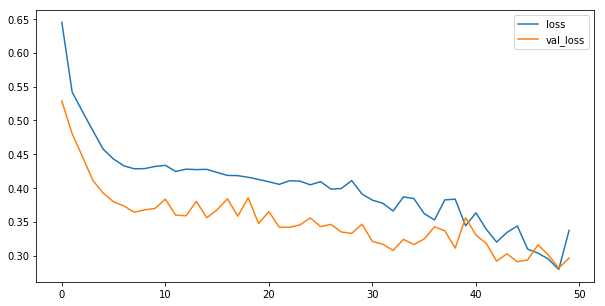

In [22]:
plt.figure(figsize=(10,5))
            
for key in ['loss', 'val_loss']:
    plt.plot(the_fcn_model.history[key],label=key)
            
plt.legend()
plt.show()

<br>

### Save the entire model

In [23]:
# Save entire model to a HDF5 file
model.save('my_model_1.h5')


<br>

### Save the model weights

In [24]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')



Consider using a TensorFlow optimizer from `tf.train`.


<br> 

## Prediction <a id='prediction'></a>
---

predictions on validation dataset using trained model. 

predictions are compared to the labeled sequences - the ground truth labels

There are 2 different predictions:
- **rna (1)**: Test how well the network can detect the hero from a distance.
- **non_rna (0)**: Test how often the network makes a mistake and identifies the wrong person as the target.


<br>

### Restore the model weights

In [ ]:
# Restore the weights
model = create_model()
model.load_weights('./checkpoints/my_checkpoint')

loss,acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('my_model_1.h5')
new_model.summary()

<br>

## Evaluation <a id='evaluation'></a>
---



In [25]:
"""
Source: https://stackoverflow.com/questions/45947351/how-to-use-tensorflow-metrics-in-keras?rq=1
Credit: Christian Skjødt
"""

def as_keras_metric(method):
  
  import functools
  import tensorflow as tf
  
  from tensorflow.keras import backend as K
  
  @functools.wraps(method)
  def wrapper(self, args, **kwargs):
    """ Wrapper for turning tensorflow metrics into keras metrics """
    value, update_op = method(self, args, **kwargs)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([update_op]):
      value = tf.identity(value)
    return value
  return wrapper
  
@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

In [26]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[precision, recall])

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[auc_pr])

<br>

### IOU

In [29]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=2)
y_testi = np.argmax(y_test, axis=2)

In [30]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)
    print('mean Intersection over Union')
    print('Mean IoU = TP/(FN + TP + FP)')
    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    print('\n\nTN = True Negative   TP = True Positives')
    print('FP = False Positive  FN = False Negatives')
    for c in range(Nclass):
        TN = np.sum( (Yi != c)&(y_predi!=c) )
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("\n class {:01.0f}: ".format(c))
        print("                         Actual       ")
        print("              ______(1)__________(0)_______")
        print("         (1) | #TP = {:6.0f}  #FP = {:6.0f}".format(TP, FP))
        print(" Predicted   |")
        print("         (0) | #FN = {:6.0f}  #TN = {:5.0f}".format(FN, TN))
        print("              _____________________________")
        print("                  IoU={:4.3f}".format(IoU))

        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("\n                _________________")
    print("                Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

mean Intersection over Union
Mean IoU = TP/(FN + TP + FP)


TN = True Negative   TP = True Positives
FP = False Positive  FN = False Negatives

 class 0: 
                         Actual       
              ______(1)__________(0)_______
         (1) | #TP =   5057  #FP =    557
 Predicted   |
         (0) | #FN =  47375  #TN = 387011
              _____________________________
                  IoU=0.095

 class 1: 
                         Actual       
              ______(1)__________(0)_______
         (1) | #TP = 387011  #FP =  47375
 Predicted   |
         (0) | #FN =    557  #TN =  5057
              _____________________________
                  IoU=0.890

                _________________
                Mean IoU: 0.493


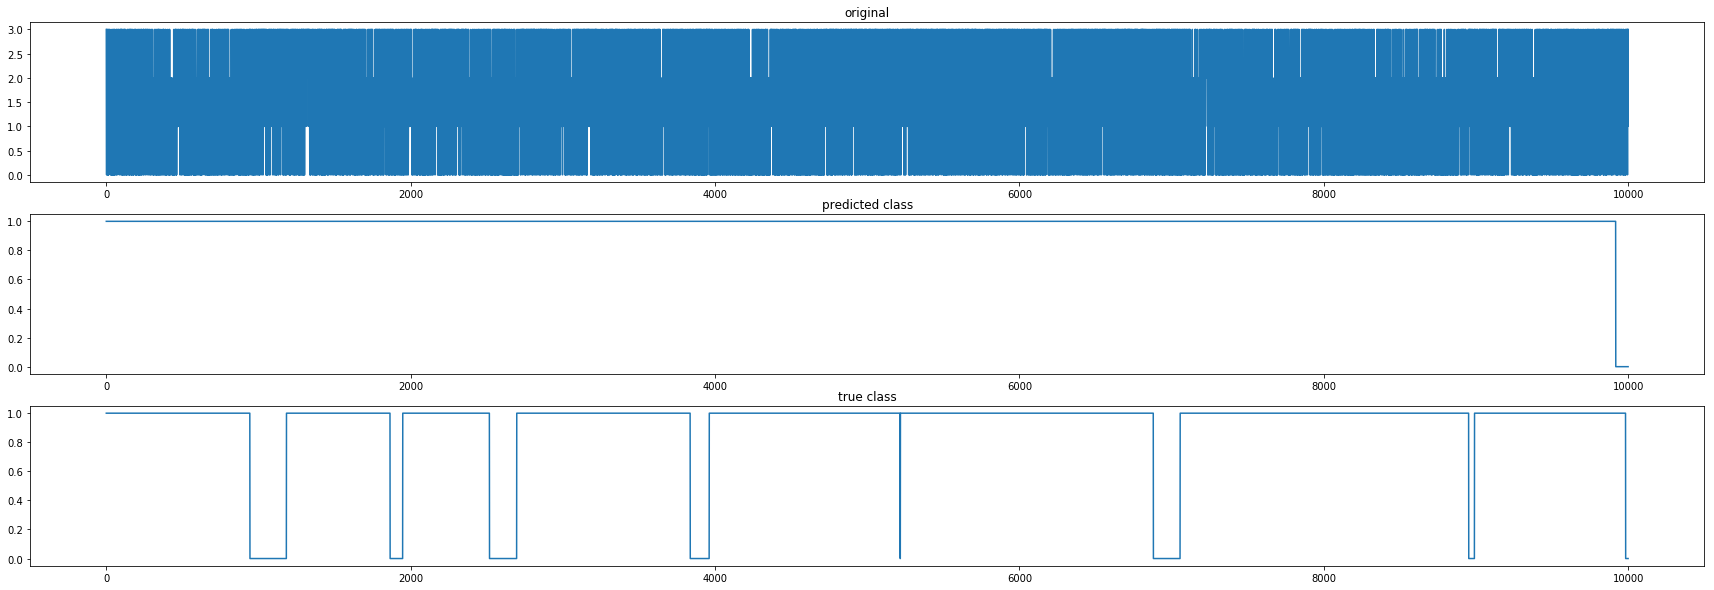

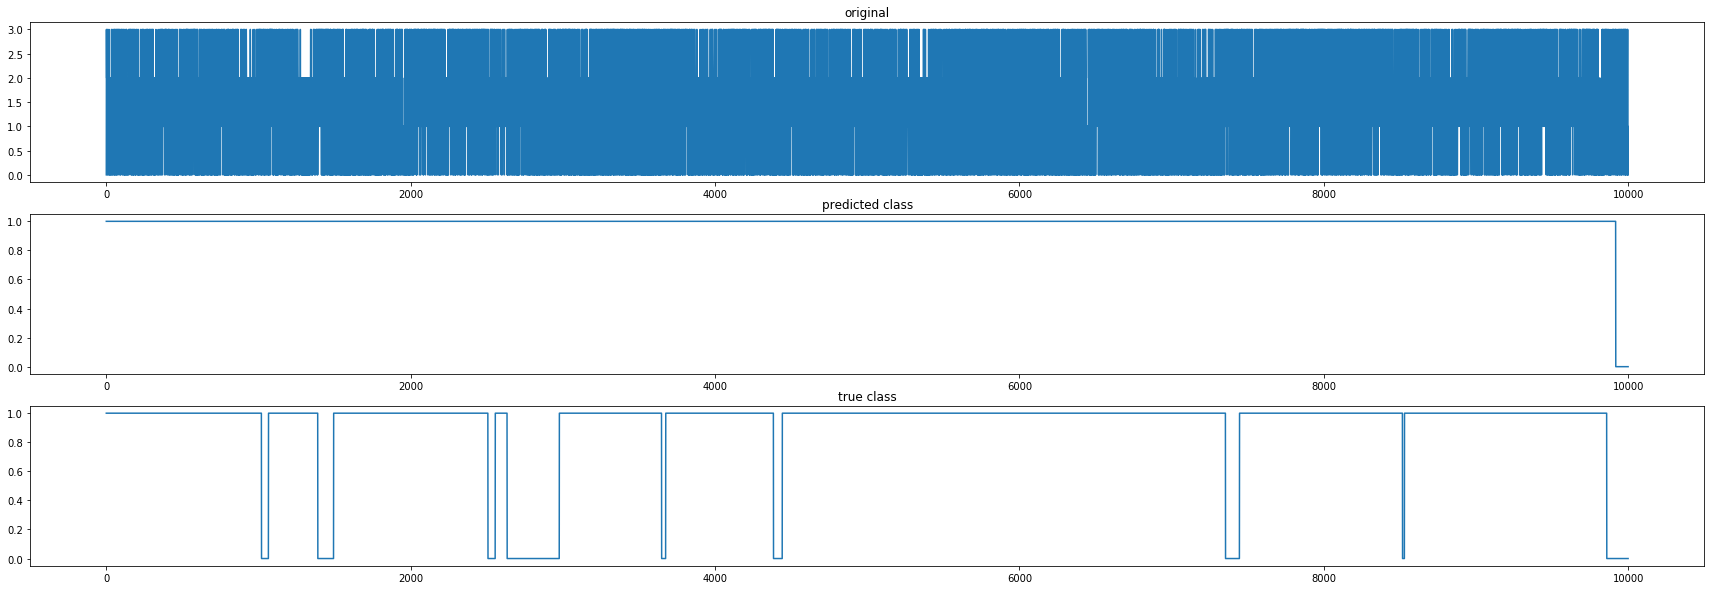

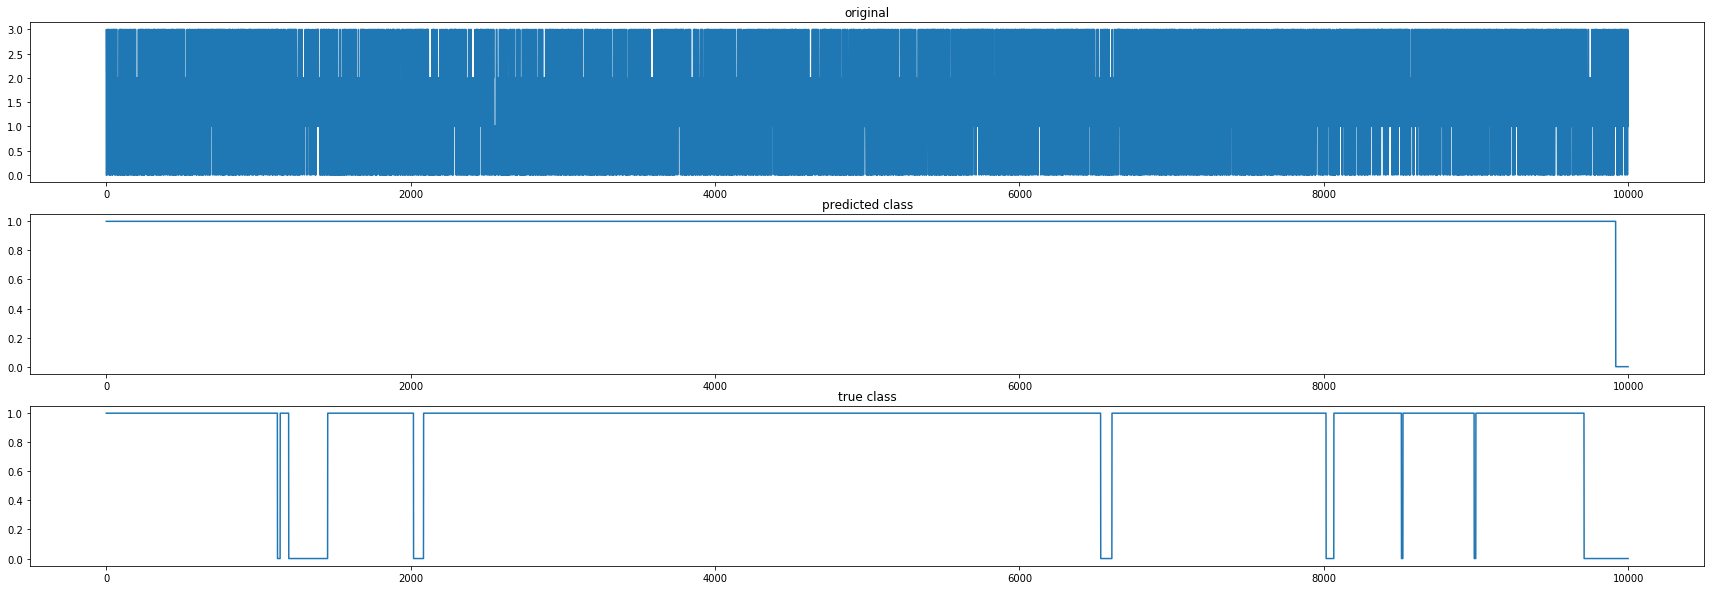

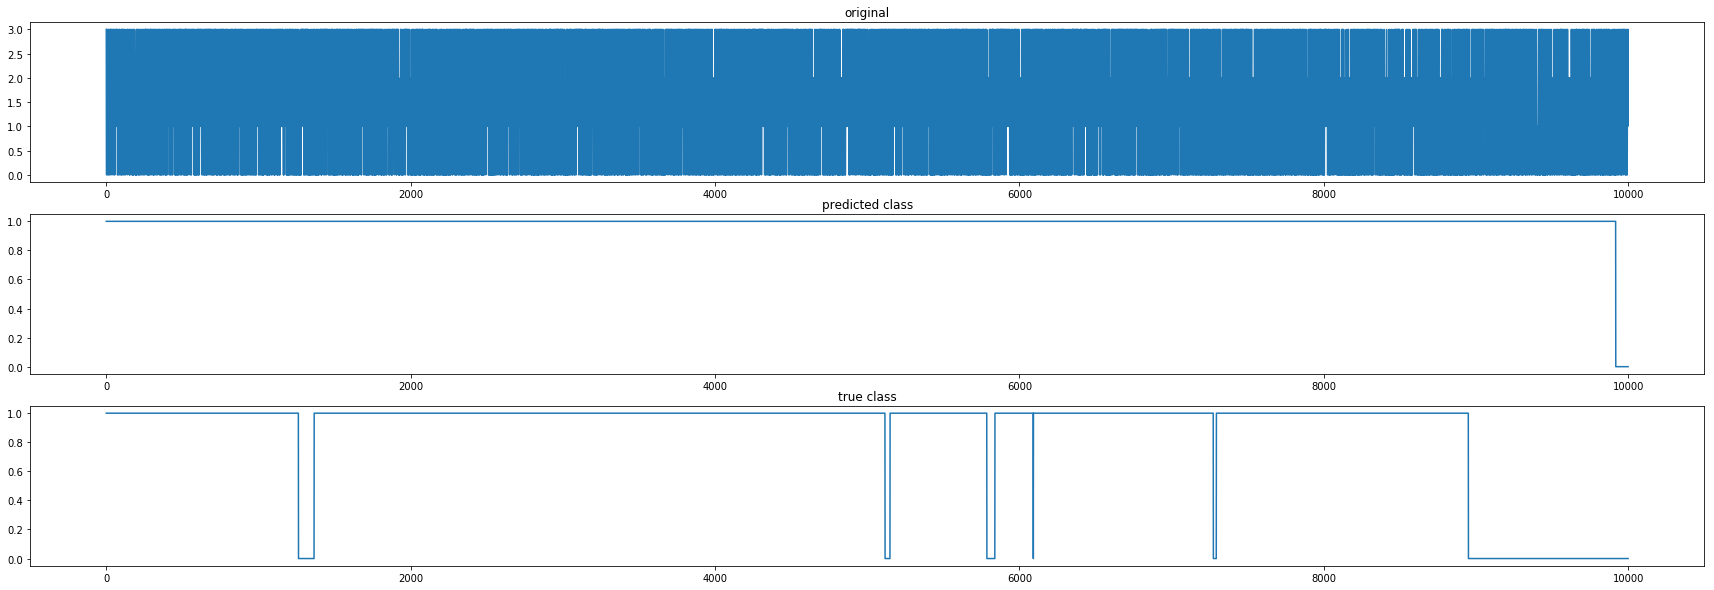

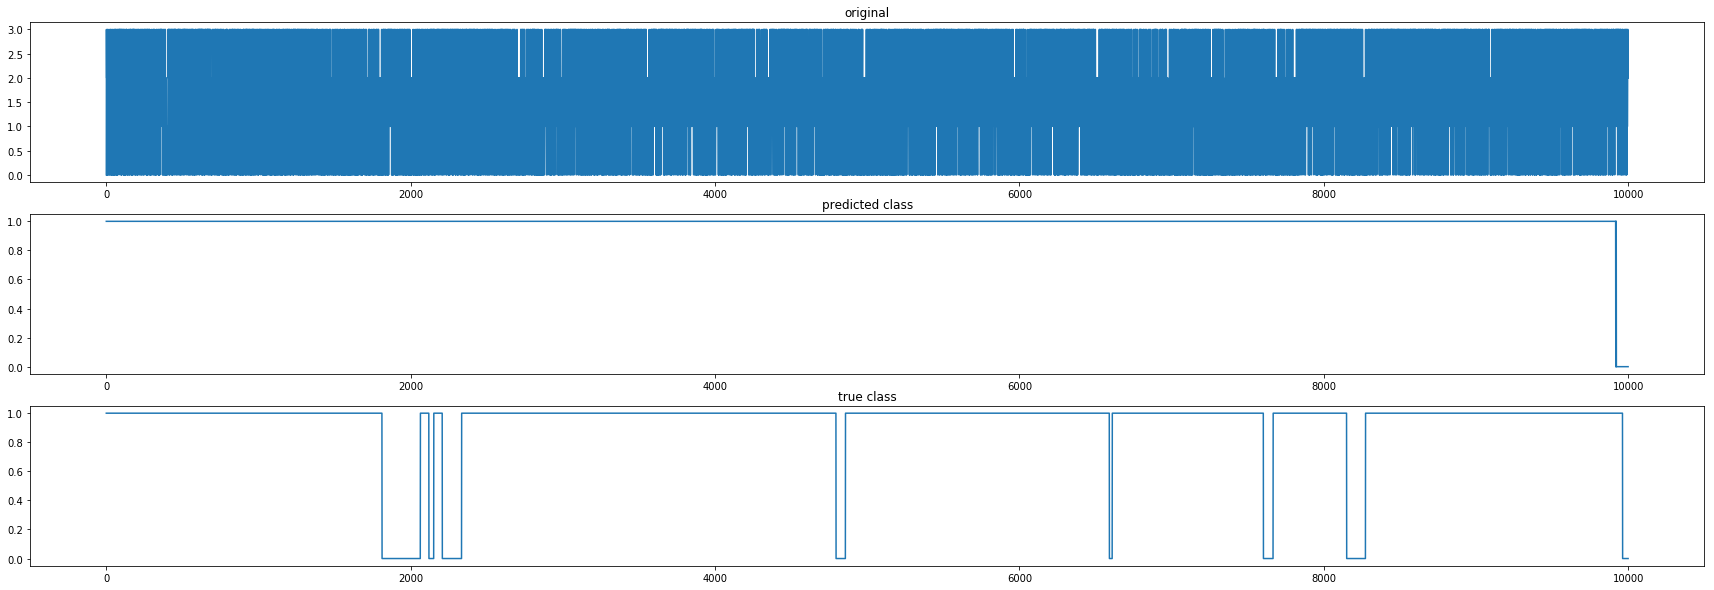

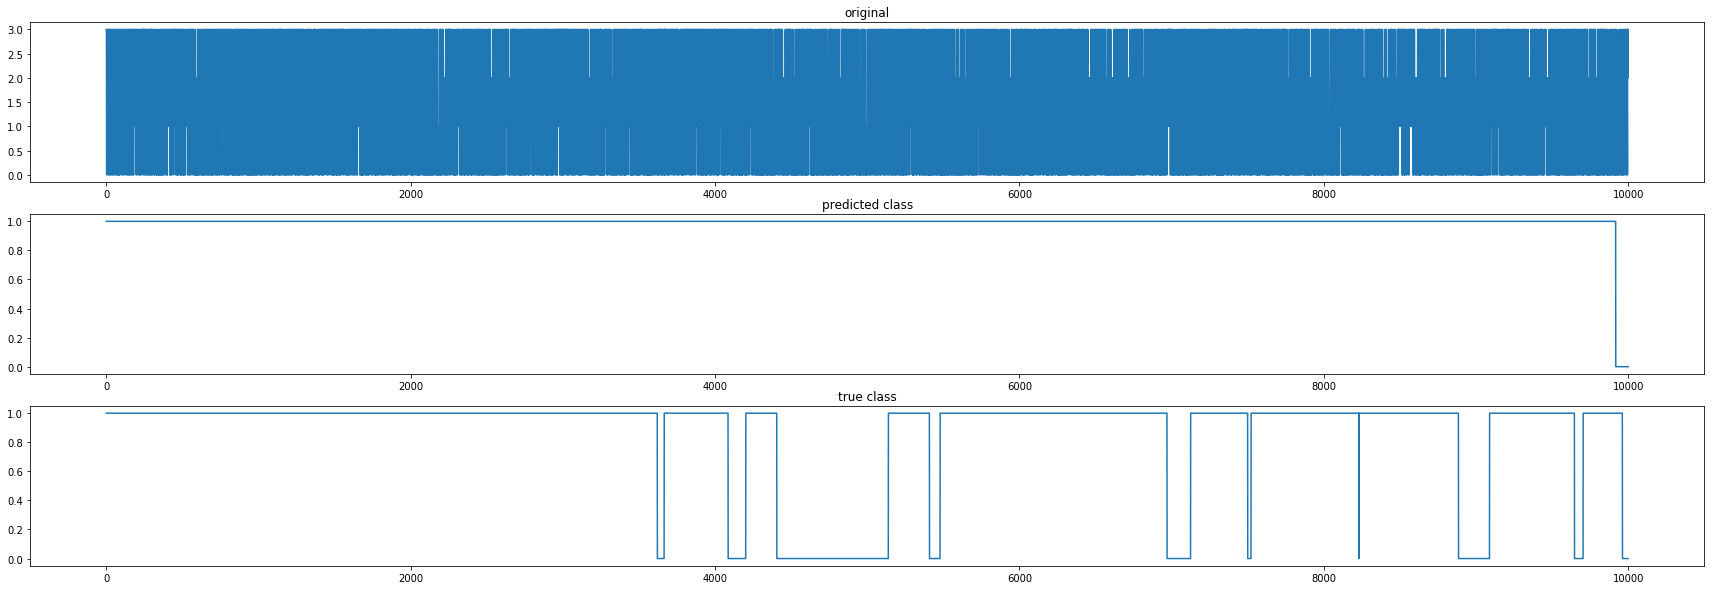

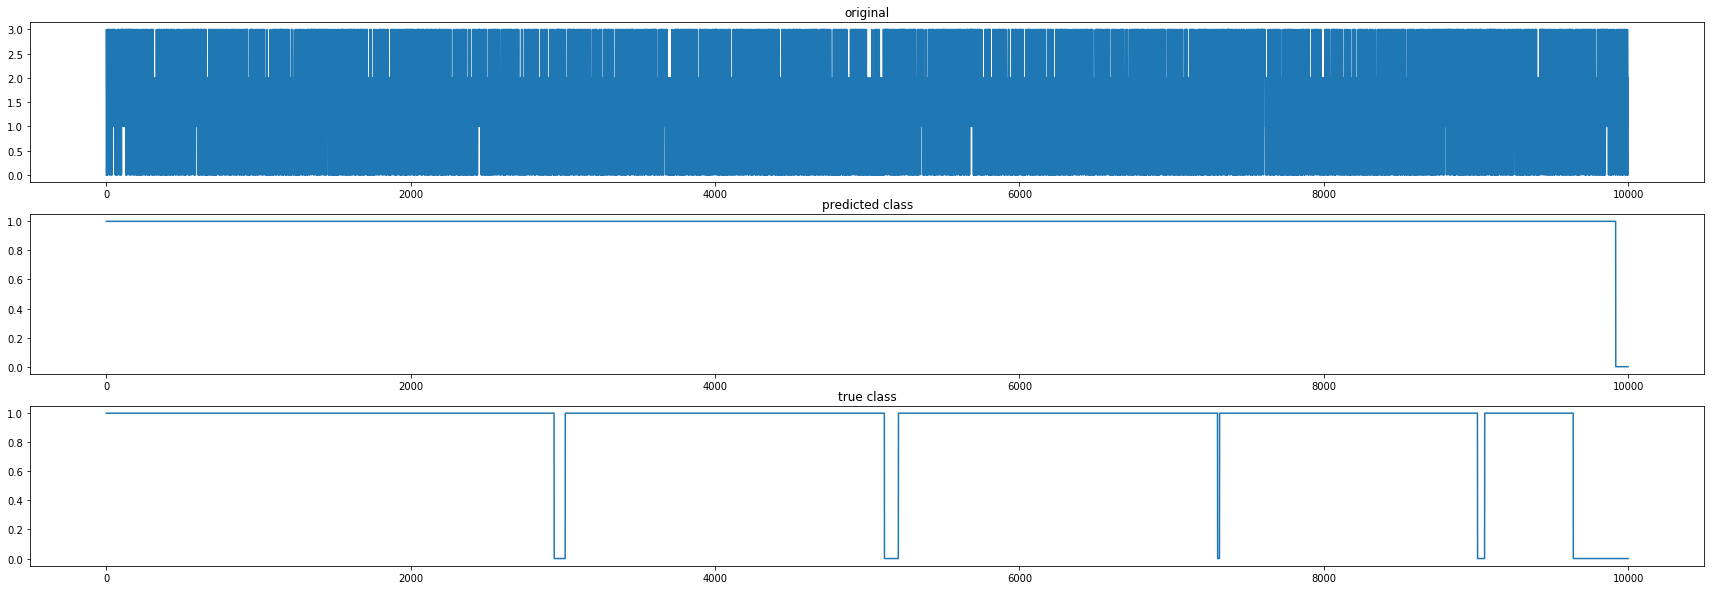

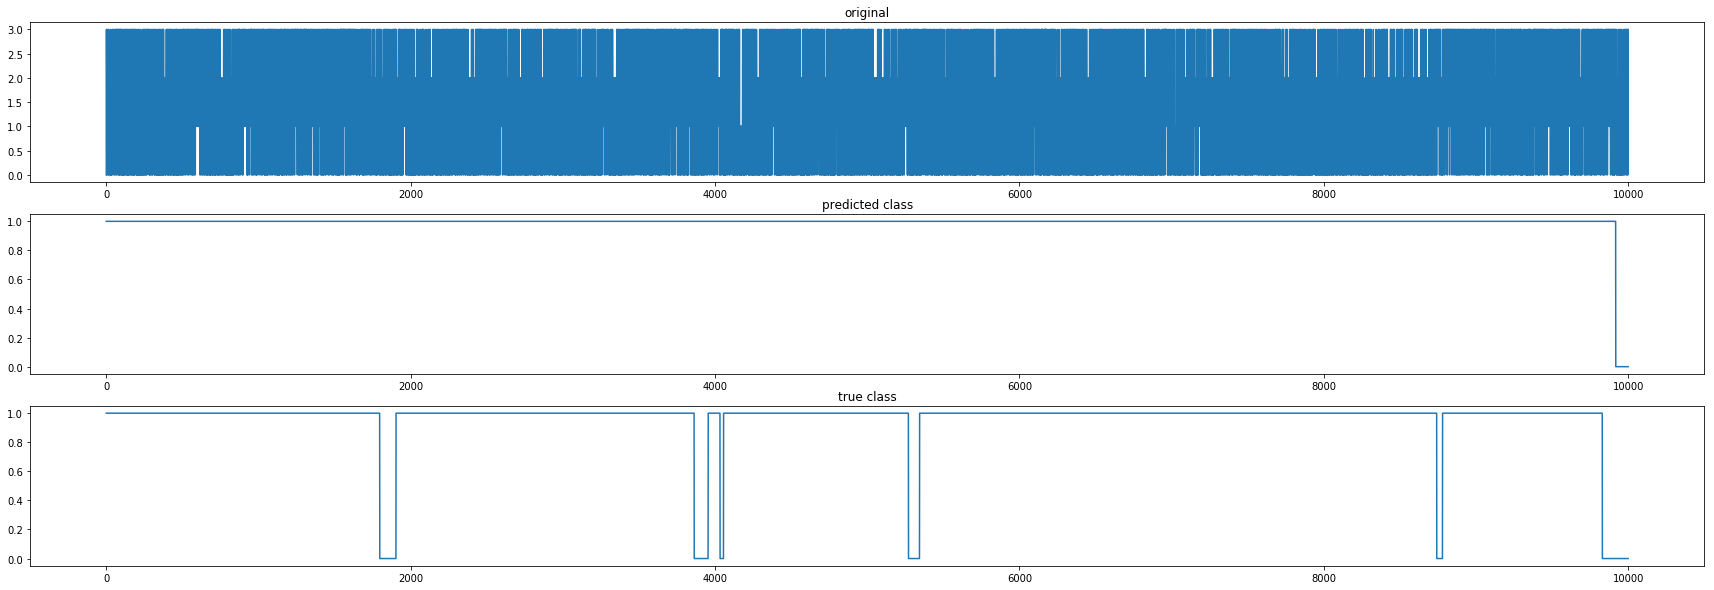

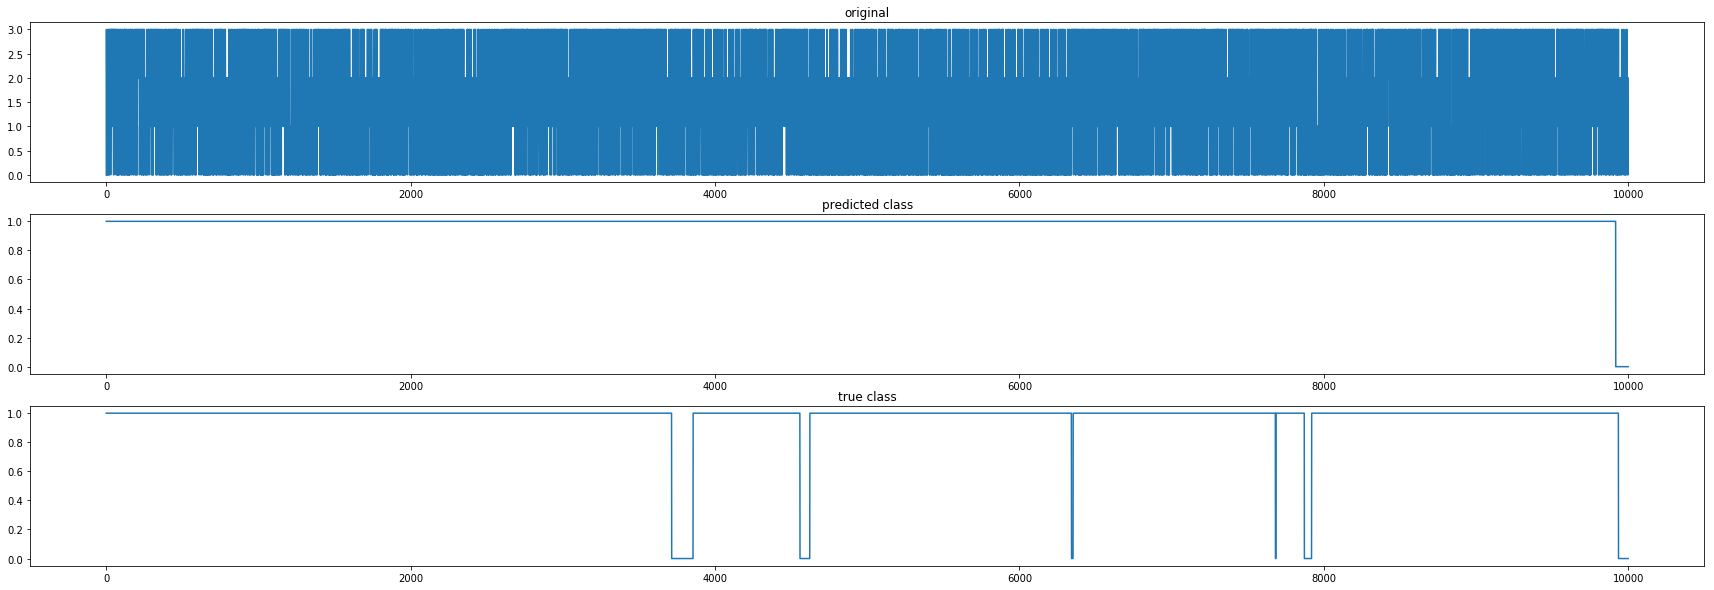

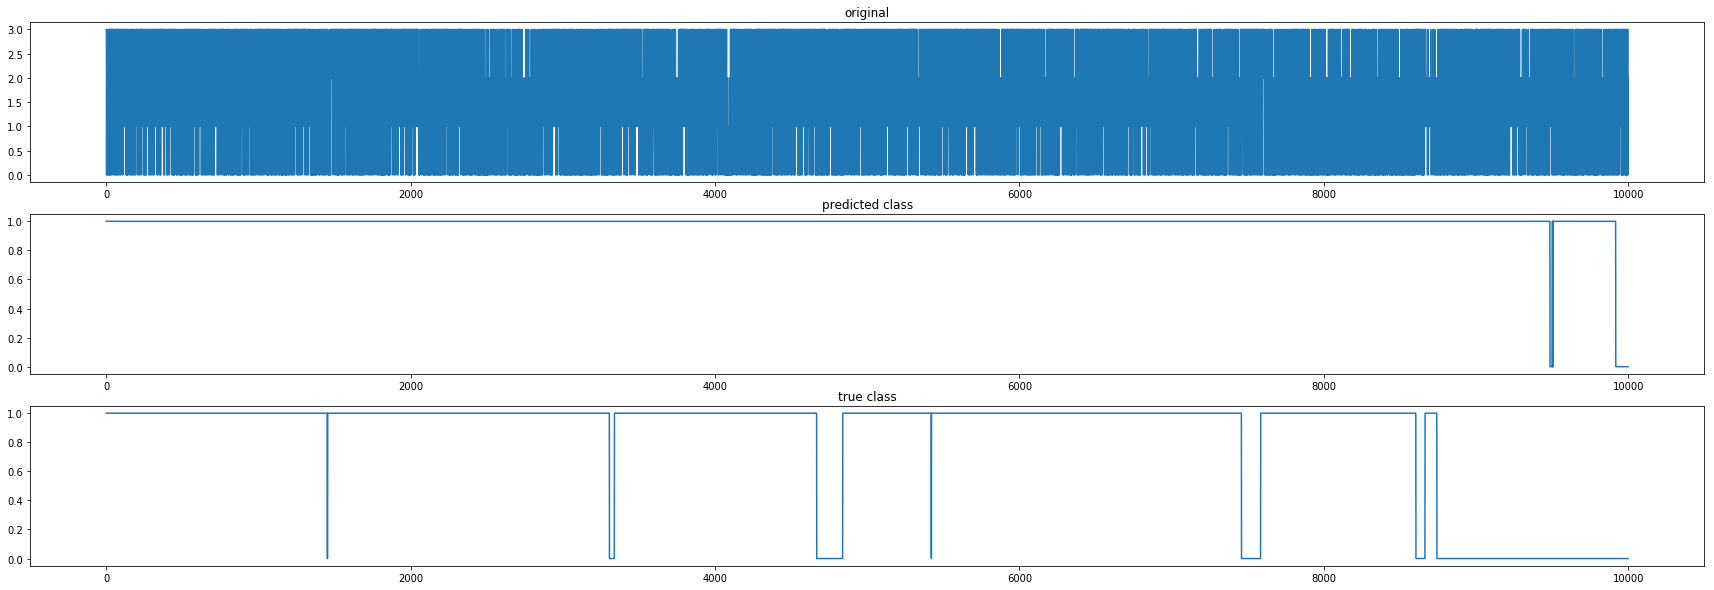

In [31]:
shape = (10000,1)
n_classes= 2

for i in range(10):
    img_is  = X_test[i]
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(30,10))    
    
    ax = fig.add_subplot(3,1,1)
    ax.plot(img_is)
    ax.set_title("original")
    
    ax = fig.add_subplot(3,1,2)
    ax.plot(seg)
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(3,1,3)
    ax.plot(segtest)
    ax.set_title("true class")
    plt.show()

<br>

### Results
---

<br>

The IOU and accuracies arn't what I hoped for. I had to segment the data because the entire genome was too large for training. 

It appears that the model learns there usually is a section at the end of a segment that isn't usually RNA, so it will predict all but the end to be RNA - since most of the sequences are RNA. 

There might be a way to incorporate another model such as Zuker to help make it more accurate. 

There are a number of other things I could have done to improve this model, including: 

- increase training time
- add more genome to train on 
- tune hyperparameters
- alter the model architecture -all more/less layers, skip connections etc.